# **Text Message Spam Detection**

We'll be using a dataset from the [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)! The file we are using contains a collection of more than 5 thousand SMS phone messages.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


load **NLTK** stopwords from the download shell

In [4]:
#after running nltk.download_shell() press l to see packages 
#we need stopwords pacakage for this project so press
# d for download and type stopwords in the shell and press enter

nltk.download_shell()


NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords
      Unzipping corpora/stopwords.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


Load our data

In [13]:
!wget https://raw.githubusercontent.com/gmashik/Machine_learning_projects/master/Spam_Filtering_project/data/SMSSpamCollection1

--2020-09-01 18:25:58--  https://raw.githubusercontent.com/gmashik/Machine_learning_projects/master/Spam_Filtering_project/data/SMSSpamCollection1
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 477907 (467K) [text/plain]
Saving to: ‘SMSSpamCollection1’

SMSSpamCollection1  100%[===================>] 466.71K  --.-KB/s    in 0.04s   

2020-09-01 18:25:58 (11.7 MB/s) - ‘SMSSpamCollection1’ saved [477907/477907]



In [15]:
#before load please mount your google drive 
msgdata=pd.read_csv('SMSSpamCollection1',sep='\t',names=['label','message']) 

In [16]:
msgdata.head(5)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Using these labeled ham and spam examples, we'll **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or spam. We'll explore our data first


In [17]:
msgdata.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

We can see we have 4516 unique ham/not spam message and most frequent is "Sorry, I'll call later". We have got this 30 times. Similarly we have 653 unique spam email. and highest frequency of the repeated message is 4.

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of feature engineering. We need a good domain knowledge on the data. Feature engineering is a very large part of spam detection in general. 
We'll make a new column to detect how long the text messages are:

In [18]:
msgdata['length']=msgdata['message'].apply(len)

In [19]:
msgdata.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


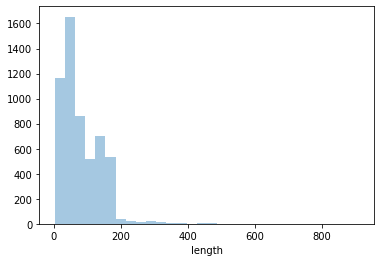

In [20]:
sns.distplot(msgdata['length'],bins=30,kde=False)

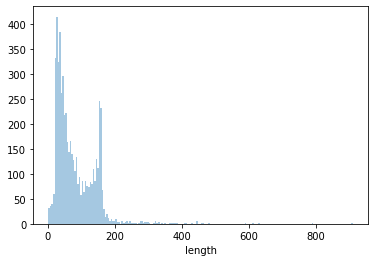

In [21]:
sns.distplot(msgdata['length'],bins=200,kde=False)

We've got a bimodal distriubution with increased number of bins

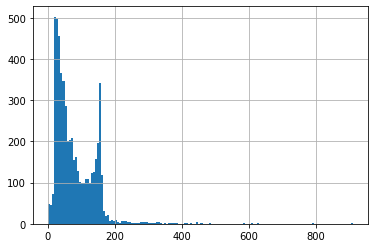

In [22]:
msgdata['length'].hist(bins=150)

If we look carefully we can see that some outliers. Let's try to explain why the x-axis goes all the way to 1000ish, this must mean that there is some really long message!

In [23]:
msgdata.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

So we have message of length 910.

The longest message is:

In [24]:
msgdata[msgdata['length']==910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb424ea3d30>,
      dtype=object)

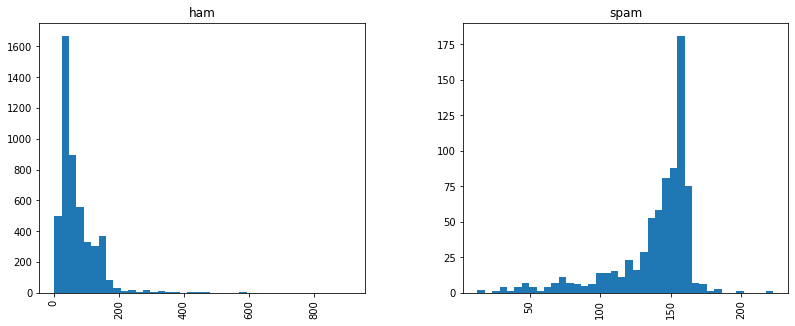

In [25]:
msgdata.hist(column='length',by='label',bins=40,figsize=(13,5))

Very interesting! Through just basic EDA we've been able to discover a trend that spam messages (their length) tend to have more characters. 

Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the bag-of-words approach, where each unique word in a text will be represented by one number.

In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

Let's create a function that will process the string in the message column, then we can just use apply() in pandas do process all the text in the DataFrame.


In [26]:
def text_processing(instr): #tokenizing 
  """
  1. Remove punctuation form each message 
  2. Remove Stop words
  3. Return processed words
  """
  puncremove=[word for word in instr if word not in string.punctuation]
  puncremove=''.join(puncremove)
  return [word for word in puncremove.split() if word.lower() not in stopwords.words('english')]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(msgdata['message'], msgdata['label'], test_size=0.3, random_state=101)

In [28]:
print(len(X_train), len(X_test), len(X_train) + len(X_test))

3900 1672 5572


We've put 70% data as training set and 30% data as test data

**We'll create scikit-learn pipeline**

Pipeline for naive bayes classifies with Multinomial naive Bayes

In [29]:
pipeline1 = Pipeline([
    ('Bag_Of_Words', CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('TF-IDF', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('Classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Pipeline for random forest classifier

In [30]:
pipeline2 = Pipeline([
    ('Bag_Of_Words', CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('TF-IDF', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('Classifier', RandomForestClassifier()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline for Bernoulli Naive Bayes classifier

In [31]:
pipeline3 = Pipeline([
    ('Bag_Of_Words', CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('TF-IDF', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('Classifier',BernoulliNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [32]:
pipeline1.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('Bag_Of_Words',
                 CountVectorizer(analyzer=<function text_processing at 0x7fb424cc2510>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('TF-IDF',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('Classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=Fal

In [33]:
pipeline2.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('Bag_Of_Words',
                 CountVectorizer(analyzer=<function text_processing at 0x7fb424cc2510>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.

In [34]:
pipeline3.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('Bag_Of_Words',
                 CountVectorizer(analyzer=<function text_processing at 0x7fb424cc2510>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('TF-IDF',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('Classifier',
                 BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                           

In [35]:
p_test1=pipeline1.predict(X_test)

In [36]:
p_test2=pipeline2.predict(X_test)

In [37]:
p_test3=pipeline3.predict(X_test)

# **Classification Report for Naive Bayes Classifier**

In [39]:
print(classification_report(p_test1,y_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1543
        spam       0.65      1.00      0.79       129

    accuracy                           0.96      1672
   macro avg       0.83      0.98      0.88      1672
weighted avg       0.97      0.96      0.96      1672



# **Classification Report for Random Forest Classifier**

In [41]:
print(classification_report(p_test2,y_test))

              precision    recall  f1-score   support

         ham       1.00      0.97      0.98      1516
        spam       0.78      0.98      0.87       156

    accuracy                           0.97      1672
   macro avg       0.89      0.98      0.93      1672
weighted avg       0.98      0.97      0.97      1672



## **Classification Report for Bernoulli Naive Bayes Classifier**

In [42]:
print(classification_report(p_test3,y_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1536
        spam       0.69      1.00      0.82       136

    accuracy                           0.96      1672
   macro avg       0.85      0.98      0.90      1672
weighted avg       0.97      0.96      0.97      1672



In [43]:
#@title Naive Bayes classifier spam detector { run: "auto", vertical-output: true, display-mode: "both" }
message = "XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL" #@param {type:"string"}
x=[]
x.append(message)
if len(x[0])==0:
  print("Please enter your message")
elif pipeline1.predict(x)[0]=='spam':
  print("The message you have given is a spam")
else:
  print("The message you have given is not spam")
x.clear()



The message you have given is not spam


In [44]:
#@title Random forest classifier spam detector { run: "auto", vertical-output: true, display-mode: "both" }
message = "XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL" #@param {type:"string"}
x=[]
x.append(message)
if len(x[0])==0:
  print("Please enter your message")
elif pipeline2.predict(x)[0]=='spam':
  print("The message you have given is a spam")
else:
  print("The message you have given is not spam")
x.clear()


The message you have given is a spam


In [45]:
#@title Bernoulli Naive Bayes classifier spam detector { run: "auto", vertical-output: true, display-mode: "both" }
message = "XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL" #@param {type:"string"}
x=[]
x.append(message)
if len(x[0])==0:
  print("Please enter your message")
elif pipeline3.predict(x)[0]=='spam':
  print("The message you have given is a spam")
else:
  print("The message you have given is not spam")
x.clear()


The message you have given is not spam


## **Conclusion**

We can see the random forest classifier performance is well than others!!!